# SCO2

[Mitochondrial complex IV deficiency nuclear type 2 (MC4DN2)](https://omim.org/entry/604377) is caused by homozygous or compound heterozygous mutation in the SCO2 gene.
[Myopia 6	(OMIM:608908)](https://omim.org/entry/608908)  is caused by heterozygous mutation in the SCO2 gene.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.4


# SCO2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SCO2.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'SCO2'
mane_tx_id = 'NM_005138.3'
mane_protein_id = 'NP_005129.2' # protein SCO2 homolog, mitochondrial precursor
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.24'
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Individuals Processed: 100%|██████████| 37/37 [00:00<00:00, 44.19 individuals/s]
Loaded 37 individuals
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
19,Hypotonia
16,Respiratory failure requiring assisted ventilation
15,Hypertrophic cardiomyopathy
10,Respiratory failure
9,Hyporeflexia
9,Cytochrome C oxidase-negative muscle fibers
7,Encephalopathy
6,Inspiratory stridor
6,Increased circulating lactate concentration
6,Brain atrophy


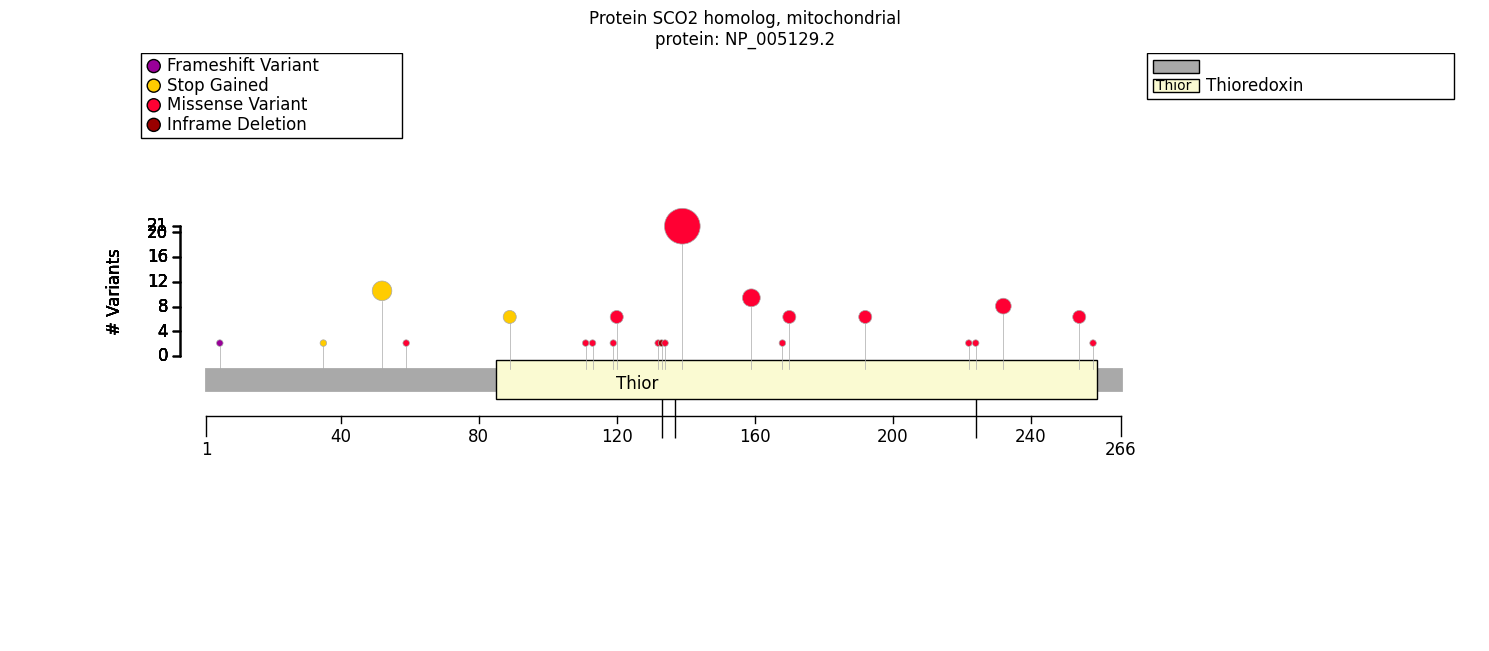

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

sco2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
sco2_fig.tight_layout()

In [6]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
21,22_50523994_50523994_C_T,c.418G>A (p.Glu140Lys),2,missense
5,22_50524255_50524255_G_A,c.157C>T (p.Gln53Ter),2,stop gained
3,22_50523715_50523715_G_T,c.697C>A (p.Pro233Thr),2,missense
3,22_50523933_50523933_A_G,c.479T>C (p.Val160Ala),2,missense
2,22_50524144_50524144_G_A,c.268C>T (p.Arg90Ter),2,stop gained
2,22_50523835_50523835_C_T,c.577G>A (p.Gly193Ser),2,missense
2,22_50524051_50524051_C_G,c.361G>C (p.Gly121Arg),2,missense
2,22_50523649_50523649_G_A,c.763C>T (p.Arg255Trp),2,missense
1,22_50524054_50524054_G_A,c.358C>T (p.Arg120Trp),2,missense
1,22_50524071_50524071_C_T,c.341G>A (p.Arg114His),2,missense


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

 The following correlation is driven by 5 patients found to be homozous for the Glu140Lys variant (PMID:15499950). The children were between the age of 8 months and 1 year and 8 months. Because of the relatively small cohort and the fact that other members of the cohort were not as young, caution is advised in the interpretation of this finding.

In [8]:
from gpsea.analysis.predicate import variant_key
from gpsea.analysis.clf import biallelic_classifier
from gpsea.view import MtcStatsViewer

glu140lys = variant_key("22_50523994_50523994_C_T") #c.418G>A	p.Glu140Lys

glu140lys_clf = biallelic_classifier(
    a_predicate=glu140lys,
    b_predicate=~glu140lys,
    a_label="Glu140Lys",
    b_label="other",
    partitions=((0,), (2,1)))
glu140lys_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=glu140lys_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(glu140lys_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,8
HMF03,Skipping term because of a child term with the same individual counts,2
HMF08,Skipping general term,84
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,211


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=glu140lys_result)

Allele group,Glu140Lys/Glu140Lys,other/other OR Glu140Lys/other,Corrected p values,p values
Hypertrophic cardiomyopathy [HP:0001639],2/6 (33%),13/13 (100%),0.02709,0.00387
Hypotonia [HP:0001252],4/5 (80%),15/15 (100%),0.87500,0.25000
Cardiomyopathy [HP:0001638],2/2 (100%),13/13 (100%),1.00000,1.00000
Reduced tendon reflexes [HP:0001315],5/5 (100%),12/12 (100%),1.00000,1.00000
Abnormal muscle tone [HP:0003808],5/5 (100%),16/16 (100%),1.00000,1.00000
Respiratory failure requiring assisted ventilation [HP:0004887],6/6 (100%),10/11 (91%),1.00000,1.00000
Respiratory insufficiency [HP:0002093],6/6 (100%),13/13 (100%),1.00000,1.00000


In [10]:
from gpsea.analysis.temporal.endpoint import hpo_onset
from gpsea.analysis.temporal.stats import LogRankTest
from gpsea.analysis.temporal import SurvivalAnalysis

term_id = "HP:0001639"  # Hypertrophic cardiomyopathy [HP:0001639]
endpoint = hpo_onset(hpo=hpo, term_id=term_id)

survival_statistic = LogRankTest()
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)

glu140lys_hcm_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=glu140lys_clf,
    endpoint=endpoint,
)

print(glu140lys_hcm_onset_result.pval)

0.21944561528684203


In [11]:
from gpsea.analysis.temporal.endpoint import disease_onset
term_id = "OMIM:604377"  # Mitochondrial complex IV deficiency, nuclear type 2		31
endpoint = disease_onset(term_id)

from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()

from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)

dx_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=glu140lys_clf,
    endpoint=endpoint,
)

print(dx_onset_result.pval)

0.41460549751219133


# Summary

In [12]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=glu140lys_result,
    ),
)

m_results = (
    GPAnalysisResultSummary.from_mono(
        result=glu140lys_hcm_onset_result,
    ),
    GPAnalysisResultSummary.from_mono(
        result=dx_onset_result,
    )
)

caption = """The glu140lys correlation is driven by 5 patients found to be homozous for the Glu140Lys variant (PMID:15499950). 
The children were between the age of 8 months and 1 year and 8 months. Because of the relatively small cohort and the fact that other members of the cohort were not as young, caution is advised in the interpretation of this finding. """

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             mono_results=m_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

HPO Term,Glu140Lys/Glu140Lys,other/other OR Glu140Lys/other,p-val,adj. p-val
Hypertrophic cardiomyopathy [HP:0001639],2/6 (33%),13/13 (100%),0.004,0.027
Description,Variable,Genotype (A),Genotype (B),p value
Survival analysis: Hypertrophic cardiomyopathy,Onset of HP:0001639,Glu140Lys/Glu140Lys,other/other OR Glu140Lys/other,0.219
Description,Variable,Genotype (A),Genotype (B),p value
Compute time until OMIM:604377 onset,Onset of OMIM:604377,Glu140Lys/Glu140Lys,other/other OR Glu140Lys/other,0.415


In [14]:
summarizer.process_latex(report=report, protein_fig=sco2_fig)

Figure saved to ../../supplement/img/SCO2_protein_diagram-draft.pdf
Output to ../../supplement/tex/SCO2_summary_draft.tex
